In [1]:
import sqlite3
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from  keys  import  client_id, api_key
import folium

In [2]:
 # Creating a new DB and setting up cursor to it
conn = sqlite3.connect('coffee_places.db')
cursor = conn.cursor()

In [6]:
# Creating dictionary where each key represents table name in DB and value represents query with Create statement with columns

TABLES = {}
TABLES['business'] = (
    """CREATE TABLE business (
        business_id VARCHAR(30) NOT NULL,
        name TEXT,
        review_count INTEGER,
        rating DECIMAL,
        address TEXT,
        city TEXT,
        zip_code INTEGER NOT NULL,
        price TEXT,
        coordinate_latitude DECIMAL,
        coordinate_longtitude DECIMAL,
        PRIMARY KEY (business_id)
        );
    """)

TABLES['reviews'] = (
    """CREATE TABLE reviews (
        review_id VARCHAR(30) PRIMARY KEY,
        business_id VARCHAR(30) NOT NULL,
        rating DECIMAL,
        text TEXT,
        date_created TEXT,
        FOREIGN KEY (business_id)
            REFERENCES business (business_id)
        
        );
    """)

In [7]:
# Itareting trough dict TABLES and executing query incoded into value of the each dict.

for table_name in TABLES:
    table_description = TABLES[table_name]
    cursor.execute('DROP TABLE IF EXISTS {};'.format(table_name))
    cursor.execute(table_description)

In [8]:
# Setting UP variables which will be using for API request to yelp web 

url =  'https://api.yelp.com/v3/businesses/search'
headers = {'Authorization': 'Bearer {}'.format(api_key)}
term = 'Coffee Shop'
locations = ['Brooklyn', 'Queens']
categories = 'Coffee & tea'
price = [1,2,3,4]
limit = 50
cur = 0

In [9]:
# 

url_params = {
                "term": term.replace(' ', '+'),
                "location": locations,
                "categories" : categories,
                "price" : price,
                "limit" : limit,
                "offset" : cur
                
            }

In [10]:
zip_queens = [11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358,
          11359, 11360, 11365, 11366, 11367, 11412, 11423, 11432, 11433,
          11434, 11435, 11436, 11101, 11102, 11103, 11104, 11105, 11106,
          11374, 11375, 11379, 11385, 11691, 11692, 11693, 11694, 11695,
          11697, 11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428,
          11429, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421,
          11368, 11369, 11370, 11372, 11373, 11377, 11378]

zip_bklyn = [11212, 11213, 11216, 11233, 11238, 11209, 11214, 11228, 11204, 11218,
          11219, 11230, 11234, 11236, 11239, 11223, 11224, 11229, 11235, 11201,
          11205, 11215, 11217, 11231, 11203, 11210, 11225, 11226, 11207, 11208,
          11211, 11222, 11220, 11232, 11206, 11221, 11237]

In [11]:
def yelp_call(url_params, api_key):
    """
    Sending API request.
    Returns data represented as list of dict.
    Each dict contain information about 1 buisness
    Params : url_params - dict
             api_key - unique key access to web
    
    """
    response = requests.get(url=url, headers=headers, params=url_params)
    data = json.loads(response.text)
    try:
        return data['businesses']
    except:
        print(data)
        return data

In [12]:
def parse_results(list_of_data):
    """
    parsing data by the keys.
    params : list_of_data - list of dict (each dict repr. 1 buisness)
    return : list of tuples with 10 elements in each
    """
    parsed_results = []
    for business in list_of_data:
        if int(business['location']['zip_code']) in zip_queens+zip_bklyn: # only takes bus located in Bklyn or Queens 
            bus_tup = (business['id'],
               business['name'],
               business['review_count'],
               business['rating'],
               ','.join(business['location']['display_address']),
               business['location']['city'],
               int(business['location']['zip_code']),
               business['price'],
               business['coordinates']['latitude'],
               business['coordinates']['longitude']
              )
            parsed_results.append(bus_tup)

    return parsed_results

In [15]:
def db_insert(cursor, parsed_results):
    """
    Inserting data into DB
    Params : cursor
             parsed_results - list of tuplease
    """
    
    insert_statement = '''INSERT INTO business (
            business_id,
            name,
            review_count,
            rating,
            address,
            city,
            zip_code,
            price,
            coordinate_latitude,
            coordinate_longtitude) VALUES ( ?, ?, ?, ?, ?, ?, ?, ?, ?, ? )'''

    cursor.executemany(insert_statement, parsed_results)

In [16]:
# Looping trough list of Location that we need to get data about
# sending each location to yelp as API reques
# getting back data then sending it to parce and collect it to all_results list
# calling function db_insert to record parced data into table Buisness in DB

all_results =[]
for location in locations:
    url_params['location'] = location
    for cur in range(0,1000,50):
        url_params['offset'] = cur
        results = yelp_call(url_params, api_key)
        parsed_results = parse_results(results)
        all_results.extend(parsed_results)
db_insert(cursor, list(set(all_results)))

In [17]:
# Retriving business_id from DB Table business and collecting into list 
business_ids = [t[0] for t in cursor.execute("""SELECT business_id FROM business;""").fetchall()]

In [18]:
def yelp_review_call(url_params, api_key, business_id):
    """
    Sending API request to yelp web.
    Returns data represented as dict with 3 keys.
    Each dict contain information about 3 buisness reviews
    Params : url_params - dict
             api_key - unique key access to web
             business_id - string
    """
    response = requests.get(url='https://api.yelp.com/v3/businesses/{}/reviews'.format(business_id), headers=headers)
    data = json.loads(response.text)
    return data

In [19]:
def parse_review(review_respond, business_id):
    """
    parsing data by the keys.
    params : review_respond - dict
             business_id - string
    return : list of tuples with 6 elements in each
    """
    parsed_results = []
    
    for review in review_respond.get('reviews',[]):
        parsed_results.append((
            review['id'],
            business_id,
            review['rating'],
            review['text'],
            review['time_created']
        ))

    return parsed_results

In [24]:
def db_insert_reviews(cursor, reviews_list):
    """
    Inserting data into DB
    Params : cursor
             reviews_list - list of tuples
    """
    
    insert_statement = '''INSERT INTO reviews (
            review_id,
            business_id,
            rating,
            text,
            date_created) VALUES ( ?, ?, ?, ?, ? )'''

    cursor.executemany(insert_statement, reviews_list)

In [22]:
# iterating troug list of business_ids
# getting data respond as dict with 3 reviews for each buisness
# parsing those 3 reviews into list of tuples 
# collecting tuples in 1 list - all_reviews

all_reviews = []
for business_id in business_ids:
    review_respond = yelp_review_call(url_params, api_key, business_id)
    all_reviews.extend(parse_review(review_respond, business_id))

In [25]:
# Insering data - list of tuples into DB Table 'reviews'
db_insert_reviews(cursor, all_reviews)

 
## SQL Questions

As a itermediary step in the process, you will need to be able to write SQL queries to answer the questions below. Each group will meet with the instructor Thursday morning to review your SQL statements.  

- Which are the 5 most reviewed businesses?
- What is the highest rating recieved in your data set and how many businesses have that rating?
- What percentage of businesses have a rating greater than or  4.5?
- What percentage of businesses have a rating less than 3?
- What is the average rating of businesses that have a price label of one dollar sign? Two dollar signs? Three dollar signs? 
- Return the text of the reviews for the most reviewed business. 
- Return the name of the business with the most recent review. 
- Find the highest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the most reviews. 
- Find the lowest rated business and return text of the most recent review.  If multiple business have the same rating, select the business with the least reviews. 


# Which are the 5 most reviewed businesses?

In [26]:
cursor.execute(""" SELECT 
                    b.name
                    ,b.review_count
                    FROM business AS b
                    ORDER BY review_count DESC
                    LIMIT 5
                """).fetchall()

[('Martha’s Country Bakery', 2039),
 ('Sweet Chick', 2026),
 ('Buttermilk Channel', 1891),
 ('JoJu', 1703),
 ('Five Leaves', 1616)]

# What is the highest rating recieved in your data set and how many businesses have that rating?


In [91]:
cursor.execute(""" SELECT 
                    rating
                    ,COUNT(rating)
                    FROM business
                    WHERE rating = (SELECT MAX(rating) FROM business)
                """).fetchall()

[(5, 34)]

# What percentage of businesses have a rating greater than or 4.5?


In [206]:

cursor.execute(""" SELECT 
                    COUNT(*)*100/(SELECT COUNT(*) FROM business)
                    FROM business
                    WHERE rating >= 4.5
                """).fetchall()

[(36,)]

# What percentage of businesses have a rating less than 3?


In [360]:
n = cursor.execute(""" SELECT 
                    COUNT(*)
                    FROM business
                    WHERE rating < 3
                """).fetchall()[0][0]
d = cursor.execute(""" SELECT 
                    COUNT(*)
                    FROM business
                    --WHERE rating < 3
                """).fetchall()[0][0]

(n/d)*100

0.8645533141210375

# What is the average rating of businesses that have a price label of one dollar sign? Two dollar signs? Three dollar signs? 

In [835]:
cursor.execute(""" SELECT 
                    price
                    ,AVG(rating)
                    FROM business
                    --WHERE price = '$' OR price = '$$' OR price = '$$$' 
                    GROUP BY price
                """).fetchall()

[('$', 4.086764705882353),
 ('$$', 4.064655172413793),
 ('$$$', 3.9166666666666665)]

# Return the text of the reviews for the most reviewed business.


In [235]:

cursor.execute("""  SELECT
                    text
                    FROM reviews 
                    WHERE business_id IN 
     
                    (SELECT
                    b.business_id
                    FROM business AS b
                    WHERE review_count IN (SELECT MAX(b.review_count) FROM business AS b) )
                """).fetchall()

[("A must have treat! Just go in and pick anything, you won't be disappointed. The workers are super nice and up beat. I left with sweets and a smile! \n\nTheir...",),
 ("Have a sweet tooth?  No problem, just pay Martha's Country Bakery a visit and you won't regret it!  There are so many selections of cakes, pies, cookies,...",),
 ("I love the Martha's in Bayside by my house as well as this location. I've dined in with friends and ordered takeout too many times to count. The pastries...",)]

# Return the name of the business with the most recent review


In [171]:
# Use subq as consume less resourses
cursor.execute(""" SELECT
                    b.name
                    ,r.date_created
                    
                    FROM business b INNER JOIN reviews r
                    ON b.business_id = r.business_id
                    ORDER BY date_created DESC
                    LIMIT 1
                """).fetchall()

[('Doughnut Plant', '2021-01-05 17:33:13')]

# Find the highest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the most reviews.

In [838]:

cursor.execute(""" SELECT
                    b.name
                    ,r.date_created
                    ,b.rating
                    ,r.text
                    ,review_count
                    FROM business b INNER JOIN reviews r
                    ON b.business_id = r.business_id
                    --GROUP BY b.business_id
                    ORDER BY  b.rating DESC, b.review_count DESC, date_created DESC
                    LIMIT 1
                """).fetchall()

[('The Alcove',
  '2020-10-06 17:23:24',
  5,
  'Never bad, always amazing-- even in the midst of covid, and notoriously long wait times. \n\nThe food and flights always makes it all better.',
  898)]

# Find the lowest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the least reviews.

In [189]:

cursor.execute(""" SELECT
                    b.name
                    ,r.date_created
                    ,b.rating
                    ,r.text
                    ,review_count
                    FROM business b INNER JOIN reviews r
                    ON b.business_id = r.business_id
                    GROUP BY b.business_id
                    ORDER BY  b.rating ASC, b.review_count DESC, date_created ASC
                    LIMIT 1
                """).fetchall()

[('Starbucks',
  '2020-06-12 14:26:31',
  2.5,
  "This isn't the worst location I've ever been to but it surely is not the best. The employees were fairly nice, but the quality of the drinks are not up to...",
  47)]

# Part 6 - Pull in relevant data into your python environment and analysis it using descriptive statistics. This can be don either using Pandas or solely Python code.

In [27]:
dfb = pd.DataFrame(cursor.execute("SELECT * FROM business").fetchall())
dfb.columns = [x[0] for x in cursor.description]
dfb.head()

,business_id,name,review_count,rating,address,city,zip_code,price,coordinate_latitude,coordinate_longtitude
0,1VBeb3BF8R8cwuCYGeMrVg,Zaca Cafe,128,4.5,"426A Marcus Garvey Blv,Brooklyn, NY 11216",Brooklyn,11216,$$,40.682230,-73.938030
1,3k8T6z664isW4DhQwD1Dag,ELEVEN36,44,4.5,"1136 President St,Brooklyn, NY 11225",Brooklyn,11225,$,40.668128,-73.953072
2,MJFtBv5iCEGXmMaLB8SD2g,The Butchers Daughter,167,3.5,"271 Metropolitan Ave,Brooklyn, NY 11211",Brooklyn,11211,$$,40.714877,-73.958543
3,s7maX59TbCDd4AuyRP_P-A,Cup,103,4.0,"79 Norman Ave,Brooklyn, NY 11222",Brooklyn,11222,$,40.725376,-73.952338
4,jxJ5cnJ4C4SkERebb4g1-w,The French Workshop,1002,4.5,"3839 Bell Blvd,Bayside, NY 11361",Bayside,11361,$$,40.765684,-73.771638


# Creating Map shoving density of Buisnesses in Queens and Brooklyn

In [28]:
# Changing 'city' column in DF business according to zip_codes

def filtering_city(row):
    
    if row['zip_code'] in zip_bklyn:
        row['city'] = 'Brooklyn'
    elif row['zip_code'] in zip_queens:
        row['city'] = 'Queens'
    return row

dfb = dfb.apply(filtering_city,axis=1)

In [1236]:
#bq_map

In [37]:
# Creating map of Brooklyn-Queens where each poin represents buisness location

bq_coordinates =[(40.6501+40.68149)/2,(-73.94958-73.83652)/2]
business_data = dfb[['coordinate_latitude','coordinate_longtitude','name','address']].values

def map_from(location, zoom_amount):
    map_ =folium.Map(location=location, zoom_start=zoom_amount)
    return map_

def add_business_mark(bus_markers_list, map_obj):
    for marker in bus_markers_list:
        marker.add_to(map_obj)
    return map_obj

map_obj = map_from(bq_coordinates, 10)
bus_markers_list = [ folium.Circle([lat,long], radius=10, tooltip=name, popup='<i>{}</i>'.format(add)) for lat,long,name,add in business_data ]

add_business_mark(bus_markers_list, map_obj)

# Scraping Data From web about zip and population in Bklyn and Queens. 

In [38]:
# creating a list of url records containing information about zip_codes and population in NYC

urls =['http://zipatlas.com/us/ny/zip-code-comparison/population-density.html'] \
    + [ 'http://zipatlas.com/us/ny/zip-code-comparison/population-density.{}.html'.format(i) for i in range(2,17)]

In [39]:
all_dfs = []

def format_table(df):
    """
    Formating each df returned
    From pd.readhtm()
    returns df
    """
    df.columns = df.iloc[0]
    return df.iloc[2:]

# looping trough list of urls and adding df from each url to all_dfs

for url in urls:
    all_dfs.append(
        format_table(
            pd.read_html(url)[10]
        )
    )

In [40]:
zip_population = pd.concat(all_dfs)
zip_population['Zip Code'] = pd.to_numeric(zip_population['Zip Code'])
zip_population['Population'] = pd.to_numeric(zip_population['Population'])
zip_population = zip_population.drop(columns=['#', 'People / Sq. Mile','National Rank'])

zip_population_bklyn = zip_population[zip_population['Zip Code'].isin(zip_bklyn)]
zip_population_bklyn.reset_index(drop=True, inplace= True)
zip_population_queens = zip_population[zip_population['Zip Code'].isin(zip_queens)]
zip_population_queens.reset_index(drop=True, inplace= True)

In [56]:
bus_count

city
Brooklyn    475
Queens      240
Name: business_id, dtype: int64

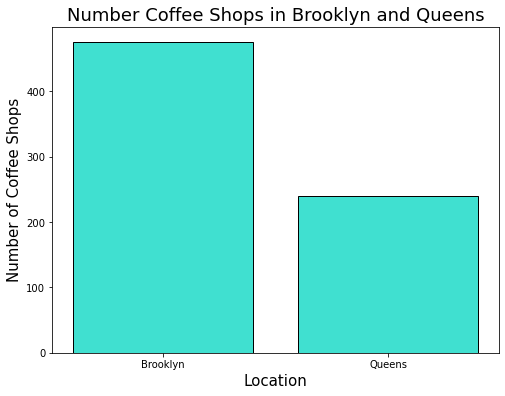

In [44]:
bus_count = dfb.groupby('city')['business_id'].count()

fig, ax = plt.subplots(figsize=(8,6))

ax.bar(bus_count.index, bus_count.values, color='turquoise', edgecolor= 'black', align='center')
ax.set_title('Number Coffee Shops in Brooklyn and Queens', size=18)
ax.set_ylabel('Number of Coffee Shops', size=15)
ax.set_xlabel('Location', size= 15)
plt.show()

# Building Graph to Show zip codes in Queens with Amount of people per Coffee Shops 

In [46]:
queens_zip_bus_count = dfb[dfb['zip_code'].isin(zip_queens)].groupby('zip_code')['zip_code'].count()
bus_count_zip_queens = dfb[dfb['city'] == 'Queens'].groupby('zip_code')['zip_code'].count()
zip_pop_count_queens = zip_population_queens.rename(columns={'Zip Code':'zip_code'}).set_index('zip_code').join(bus_count_zip_queens).rename(columns={'zip_code':'Business_count'}).dropna()

zip_pop_count_queens['customers_per_business'] = zip_pop_count_queens['Population']/zip_pop_count_queens['Business_count']
zip_pop_count_queens['customers_per_business'] = zip_pop_count_queens['customers_per_business'].map(lambda x : int(x))
zip_pop_count_queens = zip_pop_count_queens.sort_values(by ='customers_per_business')
zip_pop_count_queens['customers_per_business'] = zip_pop_count_queens['customers_per_business'].map(lambda x : int(x))
zip_pop_count_queens.reset_index(inplace=True)
rating_mean = dfb.groupby('zip_code')['rating'].mean().round(2)
zip_pop_count_queens = zip_pop_count_queens.join(rating_mean, how='left', on = 'zip_code')
zip_pop_count_queens['zip_code'] = zip_pop_count_queens['zip_code'].map(lambda x: str(x))


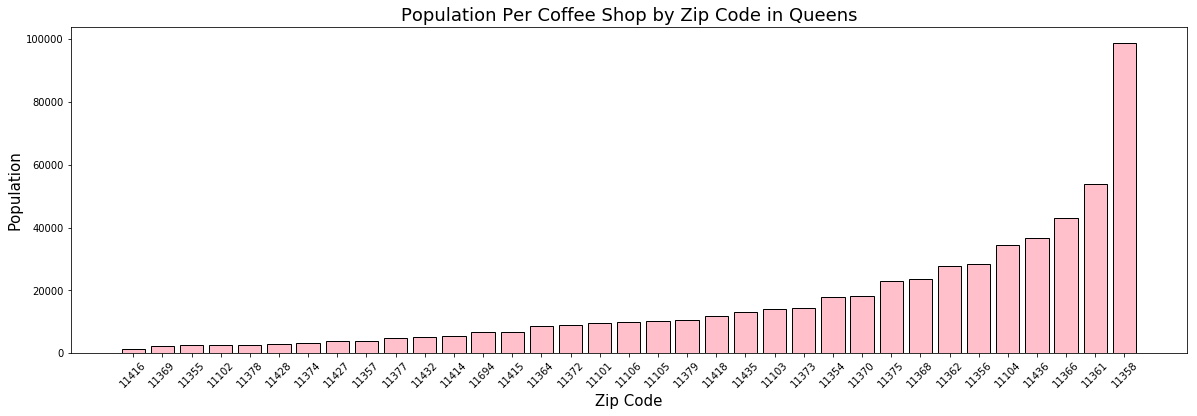

In [1260]:
fig, ax = plt.subplots(figsize=(20,6))

bars = ax.bar(zip_pop_count_queens['zip_code'] , zip_pop_count_queens['customers_per_business'], color='pink', edgecolor= 'black', align='center')
ax.set_title('Population Per Coffee Shop by Zip Code in Queens', size=18)
ax.set_ylabel('Population', size=15)
ax.set_xlabel('Zip Code', size= 15)
ax.set_xticklabels(set(zip_pop_count_queens['zip_code']), rotation =45)

plt.show()

# Prefoming analize by using weighted features

In [51]:
zip_pop_count_queens['score'] = None
zip_pop_count_queens = zip_pop_count_queens.rename(columns={'rating':'avg_rwiev_rating'})

In [54]:
# avg_rate_zip = dfq.groupby('zip_code')['rating'].mean()

pop_coef = 0.8
rate_coef = 0.20
mean_rate = 3.5

def calculate_score(row):
    if int(row['avg_rwiev_rating']) < mean_rate:
        row['score'] = row['customers_per_business'] * pop_coef + row ['avg_rwiev_rating'] * rate_coef
        row['score'] = round(row['score'])
    else:
        row['score'] = 0
    return row

In [55]:
scored_bus = zip_pop_count_queens.apply(calculate_score,axis=1).sort_values(['score'],ascending=False)
scored_bus[['zip_code','avg_rwiev_rating','score']]

,zip_code,avg_rwiev_rating,score
34,11368,3.50,79074
33,11435,3.50,43102
30,11369,3.00,28889
28,11355,3.67,22209
19,11428,3.75,8410
14,11372,3.72,6339
12,11378,3.90,5449
9,11374,3.60,3535
5,11358,3.96,2209
31,11418,4.50,0
